In [1]:
from typing import Tuple, Optional, Dict, List
import random
import torch
from torch import Tensor
from torchvision.transforms.functional import pil_to_tensor
from torchvision.datasets import MNIST
from torchvision.transforms import v2

In [2]:
transform = v2.Compose([
    v2.ToTensor(),
    # v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    #v2.Lambda(lambda x: x.view(-1) - 0.5),
])

mnist_data =  MNIST(root=".", download=True, transform=transform)

/home/andy/anaconda3/envs/ML-Practice/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
type(mnist_data)
sample = mnist_data[0]
MNIST_SIZE = sample[0].size()[1:]

MNIST_SIZE
# display(sample[0]), print(sample[1]), MNIST_SIZE

torch.Size([28, 28])

In [4]:
BATCH_SIZE = 128
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    mnist_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

In [6]:
def transform_img(img: "Image"):
    intermediate_img: Tensor = pil_to_tensor(img)
    return intermediate_img / 255

In [144]:
import logging
logger = logging.getLogger(__name__)
logger = logging.getLogger("This")
logger.setLevel(logging.INFO)

# TODO change all layer to torch.nn.LAYERTYPE


class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten_inp: torch.nn.Flatte = torch.nn.Flatten()
        # self.inp_layer: Tensor =  torch.rand(size=(MNIST_SIZE[0] * MNIST_SIZE[1], 20)).to(float)  # hidden dim=20
        self.inp_layer: torch.nn.Linear =  torch.nn.Linear(in_features=MNIST_SIZE[0] * MNIST_SIZE[1], out_features=20)
        # self.bias1: Tensor = torch.rand(20)
        # self.layer2_mu: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_mu: torch.nn.Linear = torch.nn.Linear(in_features=20, out_features=5)
        # self.layer2_sigma: Tensor = torch.rand(size=(20, 5)).to(float)
        self.layer2_sigma: torch.nn.Linear = torch.nn.Linear(in_features=20, out_features=5)
        # self.bias2_mu: Tensor = torch.rand(size=(1, 5))
        # self.bias2_sigma: Tensor = torch.rand(size=(1, 5))
        self.distr: Optional[torch.distributions.Normal] = None
        self.tanh = torch.nn.Tanh()
        return None

    def __forward__(self, x: Tensor):
        # encoder returns mu and log sigma^2
        x = self.flatten_inp(x)
        x = self.inp_layer(x)
        x = self.tanh(x)
        mu = self.layer2_mu(x)
        log_sigma_square = self.layer2_sigma(x)
        return (mu, log_sigma_square)

    def __call__(self, x: Tensor):
        return self.__forward__(x)


class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # 5 -> 100
        # 100 -> 784
        self.inp_layer: torch.nn.Linear = torch.nn.Linear(in_features=5, out_features=100)
        self.layer_1_mu: torch.nn.Linear = torch.nn.Linear(in_features=100, out_features=784)
        self.layer_1_sigma: torch.nn.Linear = torch.nn.Linear(in_features=100, out_features=784)
        self.tanh = torch.nn.Tanh()
        return None
        
    def __forward__(self, x: Tensor):
        logger.info(x.size())
        x = self.inp_layer(x)
        logger.info(x.size())
        x = self.tanh(x)
        logger.info(x.size())
        mu = self.layer_1_mu(x)
        log_sigma_square = self.layer_1_sigma(x)
        logger.info((mu.size(), log_sigma_square.size()))
        return (mu, log_sigma_square)

    def __call__(self, x: Tensor):
        return self.__forward__(x)

class VAE(torch.nn.Module):
    def __init__(self, enc: Encoder, dec: Decoder):
        super(VAE, self).__init__()
        self.enc = enc
        self.dec = dec

    def __forward__(self, x: Tensor) -> Tensor:
        mu_enc: Tensor
        log_sigma_square_enc: Tensor
        mu_dec: Tensor
        log_sigma_square_dec: Tensor

        mu_enc, log_sigma_square_enc=  self.enc(x)
        # latent_norm_enc: Dict[str, Tensor] = {"loc": x_enc[0], "scale": torch.exp(x_enc[1])}
        latent_distr: torch.distributions.MultivariateNormal = torch.distributions.MultivariateNormal(
            loc=mu_enc,
            covariance_matrix=torch.diag_embed(torch.exp(log_sigma_square_enc))
            # covariance_matrix=torch.eye(mu_enc.numel())*torch.exp(log_sigma_square_enc)
        )
        z: Tensor = latent_distr.rsample()
        
        mu_dec, log_sigma_square_dec = self.dec(z)
        reconstr_distr: torch.distributions.MultivariateNormal = torch.distributions.MultivariateNormal(
            loc=mu_dec,
            # covariance_matrix=torch.eye(mu_dec.numel())*torch.exp(log_sigma_square_dec)
            covariance_matrix=torch.diag_embed(torch.exp(log_sigma_square_dec))
        )
        reconstr_var: Tensor = reconstr_distr.rsample()
        return reconstr_var

    def encode(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # TODO rework
        mu: Tensor
        sigma: Tensor
        mu, sigma = self.enc(x)
        distr: torch.distributions.MultivariateNormal = \
            torch.distributions.MultivariateNormal(
                loc=mu,
                covariance_matrix=torch.eye(mu.numel())*sigma.pow(2)
                )
        return distr.rsample()

    def decode(self, z: Tensor) -> Tensor:
        # TODO rework
        mu: Tensor
        sigma: Tensor
        mu, sigma = self.dec(z)
        distr: torch.distributions.MultivariateNormal = \
            torch.distributions.MultivariateNormal(
                loc=mu,
                covariance_matrix=torch.eye(mu.numel())*sigma.pow(2)
                )
        return distr.rsample()

    def __call__(self, x: Tensor):
        return self.__forward__(x)

In [145]:
enc = Encoder()
some_index: int = random.randint(0, len(mnist_data))
img_tens = list(iter(mnist_data))[some_index][0]
img_tens.dtype, img_tens.size()


data_iter = iter(train_loader)
sample_batch = next(data_iter)
sample_batch[0].size()

torch.Size([64, 1, 28, 28])

In [213]:
sample_batch[0].max()

tensor(1.)

In [146]:
y = enc(sample_batch[0])
mu, sigma = y
# z = torch.distributions.MultivariateNormal(mu, torch.eye(mu.numel())*sigma.pow(2)).rsample()
z = torch.distributions.MultivariateNormal(mu, torch.diag_embed(torch.exp(sigma))).rsample()
z.size()

torch.Size([64, 5])

In [147]:
y  = enc(img_tens)
mu, sigma = y
z = torch.distributions.MultivariateNormal(mu, torch.eye(mu.numel())*sigma.pow(2)).rsample()
z

tensor([[ 0.1978, -0.0468, -0.2015, -0.5478, -0.1834]], grad_fn=<AddBackward0>)

In [148]:
dec = Decoder()
mu_x, sigma_x = dec(z)
print(mu_x.size(), sigma_x.size())
rec_sample = torch.distributions.MultivariateNormal(mu_x, torch.eye(mu_x.numel())*sigma_x.pow(2)).rsample()

torch.Size([1, 784]) torch.Size([1, 784])


In [149]:
vae = VAE(enc, dec)

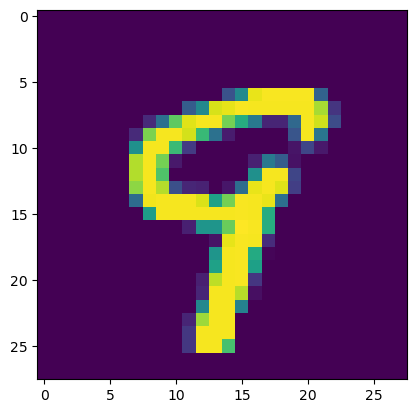

In [150]:
import matplotlib.pyplot as plt
# !conda install -y matplotlib
# display(rec_sample)
plt.imshow(img_tens[0, :, :])

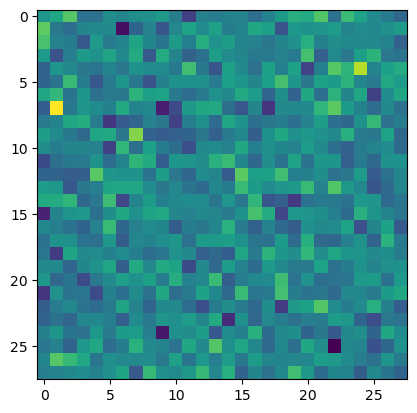

In [151]:

plt.imshow(torch.reshape(rec_sample, (28,28)).detach().numpy())


In [276]:
def elbo(x_i, mu: Tensor, log_sigma_square: Tensor, log_prob: Tensor):
    # mu is mu parametrized by encoder
    # sigma is variance as parametrized by encoder 
    # log prob is log p_{\theta}(x^{i} \mid z^{i}) or a Monte Carlo estimate based on this
    # where log p ... is just the pdf evald
    loss: Tensor = Tensor([0])
    ones: Tensor = torch.ones(log_sigma_square.size())
    mu_square: Tensor = mu.pow(2)
    intermed: Tensor = ones + log_sigma_square - mu_square - log_sigma_square.exp()
    intermed = intermed.sum(dim=1)
    final = torch.mean(- 1/2 * intermed + log_prob)

    print(f"Loss size: {loss.size()}")
    print(f"log_sigma_square size: {log_sigma_square.size()}")
    print(f"mu_square size: {mu_square.size()}")
    print(f"log_prob size: {log_prob.size()}")
    print(f"intermed size: {intermed.size()}")
    print(f"final size: {final.size()}")
    print(f"final: {final}")

    # print(loss.size(), log_sigma_square.size(), mu_square.size(), log_prob.size(), intermed.size(), final.size())
    # sigma_square: Tensor = torch.square(sigma)
    # return 1/2 * torch.mean((torch.sum(ones + log_sigma_square - mu_square - torch.exp(log_sigma_square)))+ log_prob)
    # return 1/2 * torch.mean(intermed + log_prob)
    return final
    

In [302]:
def criterion(x, x_hat, mu: Tensor, log_sigma_square: Tensor):
    # mu is mu parametrized by encoder
    # sigma is variance as parametrized by encoder 
    # log prob is log p_{\theta}(x^{i} \mid z^{i}) or a Monte Carlo estimate based on this
    # where log p ... is just the pdf evald
    rep_loss = torch.nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    loss: Tensor = Tensor([0])
    ones: Tensor = torch.ones(log_sigma_square.size())
    mu_square: Tensor = mu.pow(2)
    # print(loss.size(), log_sigma_square.size(), mu_square.size(), log_prob.size())
    # sigma_square: Tensor = torch.square(sigma)
    return torch.mean(1/2 * torch.sum(ones + log_sigma_square - mu_square - log_sigma_square.exp())) + rep_loss
    

# reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')


In [303]:
enc = Encoder()
dec = Decoder()
vae = VAE(enc, dec)


# old training function step by step
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
def train(epochs: int, vae: VAE, xs: List[Tensor]):
    optim: torch.optim.Adam = torch.optim.Adam(params=vae.parameters(),
                                              lr=LEARNING_RATE,
                                              weight_decay=WEIGHT_DECAY)
    enc: Encoder = vae.enc
    dec: Decoder = vae.dec
    # NUM_SAMPLES: int = 10
    for epoch in range(epochs):
        for i, x in enumerate(xs):
            optim.zero_grad()
            # posterior params
            enc_mu_sigma: Tuple[Tensor, Tensor] = enc.__forward__(x)
            print(f"@sample {i}: {enc_mu_sigma[0]}, {enc_mu_sigma[1]}")
            # z = torch.distributions.Normal(loc=enc_mu_sigma[0], scale=torch.exp(enc_mu_sigma[1])).rsample()
            z = torch.distributions.MultivariateNormal(loc=enc_mu_sigma[0], covariance_matrix=torch.eye(5)*torch.exp(enc_mu_sigma[1])).rsample()
            # reconstr distr params
            dec_mu_sigma: Tuple[Tensor, Tensor] = dec.__forward__(z)
            rec_distr: torch.distributions.Distribution = torch.distributions.MultivariateNormal(
                loc=dec_mu_sigma[0], covariance_matrix=torch.eye(x.size()[0])*torch.exp(dec_mu_sigma[1]))
            log_prob: Tensor = rec_distr.log_prob(x)
            loss: Tensor = elbo(x, enc_mu_sigma[0], enc_mu_sigma[1], log_prob)
            print(f"Loss @ this stage: {loss}")
            loss.backward()
            optim.step()
        print(f"Finished Iteration no {epoch}")
    return None

## Successful trainign with this training loop


In [313]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
def train(epochs: int, vae: VAE, dataloader: torch.utils.data.DataLoader):
    optim: torch.optim.Adam = torch.optim.Adam(params=vae.parameters(),
                                              lr=LEARNING_RATE,
                                              weight_decay=WEIGHT_DECAY)
    vae.train()
    enc: Encoder = vae.enc
    dec: Decoder = vae.dec
    # NUM_SAMPLES: int = 10
    for epoch in range(epochs):
        for batch_idx, (x, target) in enumerate(dataloader):
            optim.zero_grad()
            # posterior params
            enc_mu_sigma: Tuple[Tensor, Tensor] = enc.__forward__(x)
            print(f"@sample {batch_idx}: {enc_mu_sigma[0]}, {enc_mu_sigma[1]}")
            # z = torch.distributions.Normal(loc=enc_mu_sigma[0], scale=torch.exp(enc_mu_sigma[1])).rsample()
            z = torch.distributions.MultivariateNormal(
                loc=enc_mu_sigma[0], 
                covariance_matrix=torch.diag_embed(torch.exp(enc_mu_sigma[1]))).rsample()
                # covariance_matrix=torch.eye(5)*torch.exp(enc_mu_sigma[1])).rsample()
            # reconstr distr params
            dec_mu_sigma: Tuple[Tensor, Tensor] = dec.__forward__(z)
            rec_distr: torch.distributions.Distribution = torch.distributions.MultivariateNormal(
                loc=dec_mu_sigma[0], covariance_matrix=torch.diag_embed(torch.exp(dec_mu_sigma[1])))
                # loc=dec_mu_sigma[0], covariance_matrix=torch.eye(x.size()[0])*torch.exp(dec_mu_sigma[1]))
            # log_prob: Tensor = rec_distr.log_prob(torch.flatten(x, start_dim=1))
            # loss: Tensor = elbo(x, enc_mu_sigma[0], enc_mu_sigma[1], log_prob)
            x_hat = torch.sigmoid(rec_distr.rsample())
            print(f"x_hat: {x.min(), x.max(), x_hat.min(), x_hat.max()} ")
            loss: Tensor = criterion(x.flatten(start_dim=1), x_hat, enc_mu_sigma[0], enc_mu_sigma[1])

            print(f"Loss @ this stage: {loss}")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)    
            optim.step()
        print(f"Finished Iteration no {epoch}")
    return None

## trying with actual reconstruction error

In [281]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0
def train(epochs: int, vae: VAE, dataloader: torch.utils.data.DataLoader):
    optim: torch.optim.Adam = torch.optim.Adam(params=vae.parameters(),
                                              lr=LEARNING_RATE,
                                              weight_decay=WEIGHT_DECAY)
    vae.train()
    enc: Encoder = vae.enc
    dec: Decoder = vae.dec
    # NUM_SAMPLES: int = 10
    for epoch in range(epochs):
        for batch_idx, (x, target) in enumerate(dataloader):
            optim.zero_grad()
            # posterior params
            enc_mu_sigma: Tuple[Tensor, Tensor] = enc.__forward__(x)
            print(f"@sample {batch_idx}: {enc_mu_sigma[0]}, {enc_mu_sigma[1]}")
            # z = torch.distributions.Normal(loc=enc_mu_sigma[0], scale=torch.exp(enc_mu_sigma[1])).rsample()
            z = torch.distributions.MultivariateNormal(
                loc=enc_mu_sigma[0], 
                covariance_matrix=torch.diag_embed(torch.exp(enc_mu_sigma[1]))).rsample(sample_shape=torch.Size([10]))
                # covariance_matrix=torch.eye(5)*torch.exp(enc_mu_sigma[1])).rsample()
            # reconstr distr params
            dec_mu_sigma: Tuple[Tensor, Tensor] = dec.__forward__(z)
            rec_distr: torch.distributions.Distribution = torch.distributions.MultivariateNormal(
                loc=dec_mu_sigma[0], covariance_matrix=torch.diag_embed(torch.exp(dec_mu_sigma[1])))
                # loc=dec_mu_sigma[0], covariance_matrix=torch.eye(x.size()[0])*torch.exp(dec_mu_sigma[1]))
            log_prob: Tensor = - rec_distr.log_prob(torch.flatten(x, start_dim=1)).mean(dim=0)
            loss: Tensor = elbo(x, enc_mu_sigma[0], enc_mu_sigma[1], log_prob)
            # x_hat = torch.sigmoid(rec_distr.rsample())
            # loss: Tensor = criterion(x.flatten(start_dim=1), x_hat, enc_mu_sigma[0], enc_mu_sigma[1])
            # print(f"x_hat: {x.min(), x.max(), x_hat.min(), x_hat.max()} ")

            print(f"Loss @ this stage: {loss}")
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)    
            optim.step()
        print(f"Finished Iteration no {epoch}")
    return None

def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader) 

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from VAE import train, VAE, Encoder, Decoder

In [7]:
enc = Encoder(MNIST_SIZE)
dec = Decoder()
vae = VAE(enc, dec)

In [8]:
from VAE import train

In [9]:
train(epochs=20, vae=vae, dataloader=train_loader)

100%|██████████| 469/469 [02:00<00:00,  3.89it/s]


Finished Iteration no 0 with loss: 6274320.176269531


100%|██████████| 469/469 [01:59<00:00,  3.92it/s]


Finished Iteration no 1 with loss: 3423646.498046875


100%|██████████| 469/469 [01:58<00:00,  3.95it/s]


Finished Iteration no 2 with loss: 3284636.400390625


100%|██████████| 469/469 [01:59<00:00,  3.94it/s]


Finished Iteration no 3 with loss: 3164120.1572265625


100%|██████████| 469/469 [01:52<00:00,  4.17it/s]


Finished Iteration no 4 with loss: 2987600.1762695312


100%|██████████| 469/469 [01:38<00:00,  4.74it/s]


Finished Iteration no 5 with loss: 2864067.2260742188


100%|██████████| 469/469 [01:06<00:00,  7.09it/s]


Finished Iteration no 6 with loss: 2708968.12890625


100%|██████████| 469/469 [01:05<00:00,  7.12it/s]


Finished Iteration no 7 with loss: 2579349.4272460938


100%|██████████| 469/469 [01:04<00:00,  7.32it/s]


Finished Iteration no 8 with loss: 2470698.3012695312


100%|██████████| 469/469 [01:04<00:00,  7.31it/s]


Finished Iteration no 9 with loss: 2374933.6708984375


100%|██████████| 469/469 [01:04<00:00,  7.30it/s]


Finished Iteration no 10 with loss: 2309342.6557617188


100%|██████████| 469/469 [01:04<00:00,  7.27it/s]


Finished Iteration no 11 with loss: 2264175.8134765625


100%|██████████| 469/469 [01:04<00:00,  7.28it/s]


Finished Iteration no 12 with loss: 2231238.2065429688


100%|██████████| 469/469 [01:04<00:00,  7.30it/s]


Finished Iteration no 13 with loss: 2206964.1606445312


100%|██████████| 469/469 [01:04<00:00,  7.27it/s]


Finished Iteration no 14 with loss: 2188438.333984375


100%|██████████| 469/469 [01:04<00:00,  7.29it/s]


Finished Iteration no 15 with loss: 2171298.7504882812


100%|██████████| 469/469 [01:04<00:00,  7.29it/s]


Finished Iteration no 16 with loss: 2155112.5864257812


100%|██████████| 469/469 [01:04<00:00,  7.30it/s]


Finished Iteration no 17 with loss: 2143398.1577148438


100%|██████████| 469/469 [01:04<00:00,  7.29it/s]


Finished Iteration no 18 with loss: 2127810.637939453


100%|██████████| 469/469 [01:04<00:00,  7.28it/s]

Finished Iteration no 19 with loss: 2115767.3549804688


In [10]:
sample[0].size()

torch.Size([1, 28, 28])

In [11]:
import matplotlib.pyplot as plt

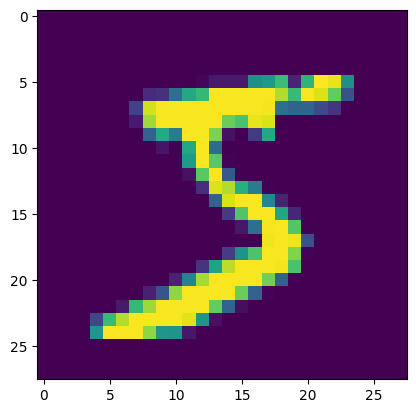

In [12]:
plt.imshow(sample[0].detach().numpy().reshape(28,28))

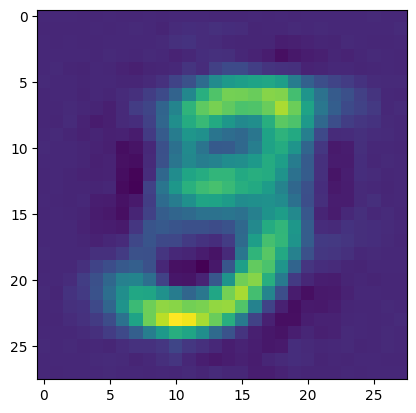

: 

In [34]:
plt.imshow(vae.to(torch.device("cpu"))(sample[0].to(torch.device("cpu"))).detach().numpy().reshape(28,28))


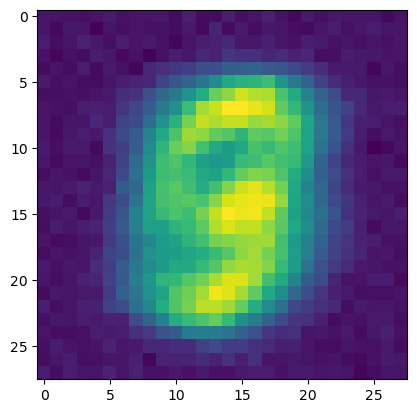

In [59]:

plt.imshow(vae(sample[0]).detach().numpy().reshape(28,28))

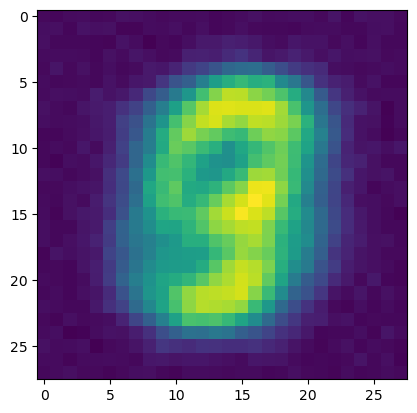

In [61]:
plt.imshow(vae(sample[0]).detach().numpy().reshape(28,28))

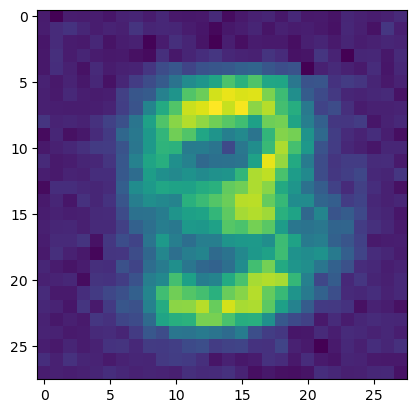

In [98]:
plt.imshow(vae(sample[0]).detach().numpy().reshape(28,28))

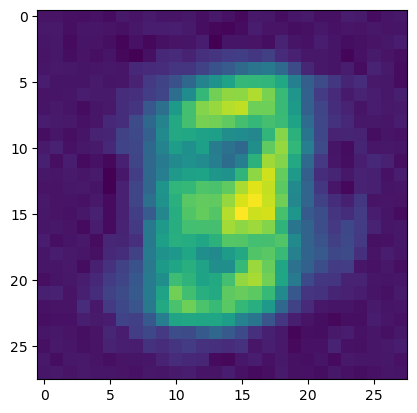

In [74]:

plt.imshow(vae(sample[0]).detach().numpy().reshape(28,28))

In [21]:
sample_batch[0]

NameError: name 'sample_batch' is not defined

In [ ]:

vae(sample_batch[0]).size()

torch.Size([64, 784])

In [31]:
plt.imshow(vae(sample_batch[0])[0].detach().numpy().reshape(28,28))
# plt.imshow(sample_batch[0][3].reshape(28,28))

NameError: name 'sample_batch' is not defined

In [284]:
plt.imshow(vae.dec(torch.distributions.MultivariateNormal(torch.ones(5), covariance_matrix=torch.diag_embed(torch.ones(5))).rsample().detach().numpy()))

TypeError: 'int' object is not callable